## Brouillon Diane

In [58]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

### Données BNP min par min, trop high frequency pour notre analyse

In [45]:
bnp = pd.read_excel('dataset_Prices/BNP_Prices.xlsx')

In [46]:
bnp.head()

,BNP FP Equity,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Dates,Open,Close,High,Low
1,2022-09-13 09:00:00.005000,50.8,50.84,50.91,50.75
2,2022-09-13 09:01:00,50.86,50.91,50.91,50.85
3,2022-09-13 09:02:00,50.87,50.87,50.9,50.84
4,2022-09-13 09:03:00,50.88,50.86,50.91,50.82


### Daily returns JPM et SP500

In [47]:
start_date = '2005-01-01'
end_date = '2023-12-31'

data_JPM = yf.download(tickers="JPM", start=start_date, end=end_date)

C:\Users\diane\AppData\Local\Temp\ipykernel_171524\1991613486.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_JPM = yf.download(tickers="JPM", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [48]:
data_SP500 = yf.download(tickers="^GSPC", start=start_date, end=end_date)
print("data_SP500 shape : ", data_SP500.shape)
data_SP500.tail()


C:\Users\diane\AppData\Local\Temp\ipykernel_171524\2591821409.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_SP500 = yf.download(tickers="^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

data_SP500 shape :  (4781, 5)


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000
2023-12-27,4781.580078,4785.390137,4768.899902,4773.450195,2748450000
2023-12-28,4783.350098,4793.299805,4780.979980,4786.439941,2698860000
2023-12-29,4769.830078,4788.430176,4751.990234,4782.879883,3126060000


In [49]:
dates = np.array(data_SP500.index)
values = np.array(data_SP500['Close'])

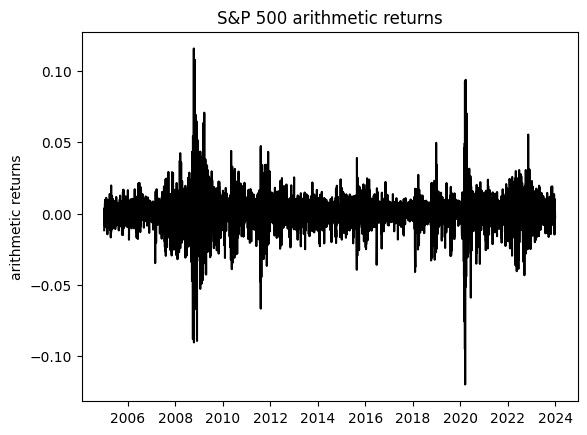

In [50]:
arithmetic_returns_aux = (values[1:] - values[0:-1]) / values[0:-1]
arithmetic_returns=arithmetic_returns_aux.flatten() #from a 2D array (n,1) in a 1D array
return_dates = dates[1:]

plt.plot(return_dates, arithmetic_returns, color='k')
plt.title("S&P 500 arithmetic returns")
plt.ylabel("arithmetic returns")
plt.show()

In [51]:
r = arithmetic_returns - np.mean(arithmetic_returns)      # centrage

# choix du lag avec AIC
aic_vals = []
p_max = 10
for p in range(1, p_max+1):
    model = sm.tsa.ARIMA(r, order=(p,0,0)).fit()
    aic_vals.append(model.aic)

p_opt = np.argmin(aic_vals) + 1
print("p optimal =", p_opt)

# fit le modèle ar(p)
model_ar = sm.tsa.ARIMA(r, order=(p_opt,0,0)).fit()
print(model_ar.summary())

# prediction 1 step ahead
forecast = model_ar.forecast(steps=1)
print("Prévision AR(1-step) :", forecast[0])

c:\Users\diane\time-series-pred\tspenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p optimal = 9
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4780
Model:                 ARIMA(9, 0, 0)   Log Likelihood               14319.477
Date:                Tue, 06 Jan 2026   AIC                         -28616.954
Time:                        22:26:43   BIC                         -28545.760
Sample:                             0   HQIC                        -28591.944
                               - 4780                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.965e-06      0.000     -0.018      0.986      -0.000       0.000
ar.L1         -0.1252      0.007    -16.974      0.000      -0.140      -0.111
ar.L2         -0.0201      0.006     -

### Apple prediction

#### Acquisition des données et FE

In [52]:
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

df_aapl = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    auto_adjust=True,
    progress=False
)

df_aapl = df_aapl[["Close"]].copy()
df_aapl["log_return"] = np.log(df_aapl["Close"] / df_aapl["Close"].shift(1))

# we delete the NAN created by the shift IN THE log returns
df_aapl.dropna(inplace=True) 

# Outlier handling (meilleure pred de 0.0001 MSE avec ça)
#lower, upper = df_aapl["log_return"].quantile([0.01, 0.99])
#df_aapl["log_return"] = df_aapl["log_return"].clip(lower, upper)

# Feature engineering
# Lagged returns (autoregressive structure)
for lag in range(1,11):
    df_aapl[f"ret_lag_{lag}"] = df_aapl["log_return"].shift(lag)

# Rolling volatility (risk signal)
#df_aapl["vol_20"] = df_aapl["log_return"].rolling(20).std()
#df_aapl["vol_60"] = df_aapl["log_return"].rolling(60).std()     

# Drop rows with NaN from lags / rolling windows
df_aapl.dropna(inplace=True)

y = df_aapl["log_return"] # target : next-day log return
X = df_aapl.drop(columns=["Close", "log_return"]) # drop price & target, pour faire la matrice X de feature

print(X.head())
print(y.describe())

Price      ret_lag_1 ret_lag_2 ret_lag_3 ret_lag_4 ret_lag_5 ret_lag_6  \
Ticker                                                                   
Date                                                                     
2010-01-20  0.043288 -0.016853 -0.005809  0.014007 -0.011440 -0.008861   
2010-01-21 -0.015512  0.043288 -0.016853 -0.005809  0.014007 -0.011440   
2010-01-22 -0.017438 -0.015512  0.043288 -0.016853 -0.005809  0.014007   
2010-01-25 -0.050871 -0.017438 -0.015512  0.043288 -0.016853 -0.005809   
2010-01-26  0.026547 -0.050871 -0.017438 -0.015512  0.043288 -0.016853   

Price      ret_lag_7 ret_lag_8 ret_lag_9 ret_lag_10  
Ticker                                               
Date                                                 
2010-01-20  0.006626 -0.001850 -0.016034   0.001727  
2010-01-21 -0.008861  0.006626 -0.001850  -0.016034  
2010-01-22 -0.011440 -0.008861  0.006626  -0.001850  
2010-01-25  0.014007 -0.011440 -0.008861   0.006626  
2010-01-26 -0.005809  0.01400

#### EDA

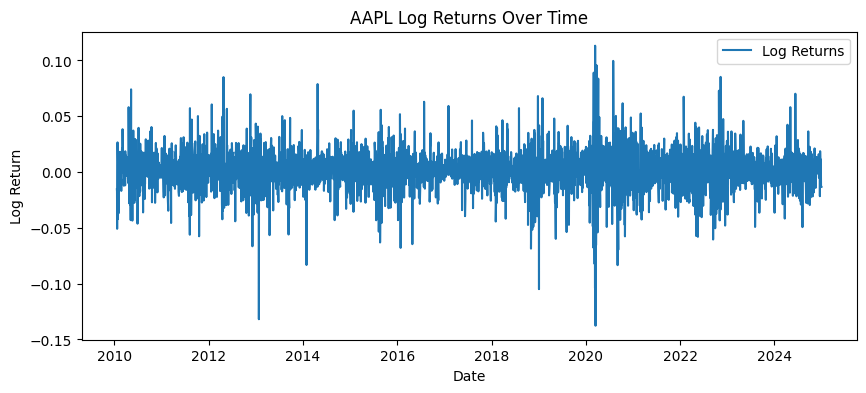

In [53]:
plt.figure(figsize=(10, 4))
plt.plot(df_aapl.index, df_aapl["log_return"], label="Log Returns")
plt.title("AAPL Log Returns Over Time") 
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

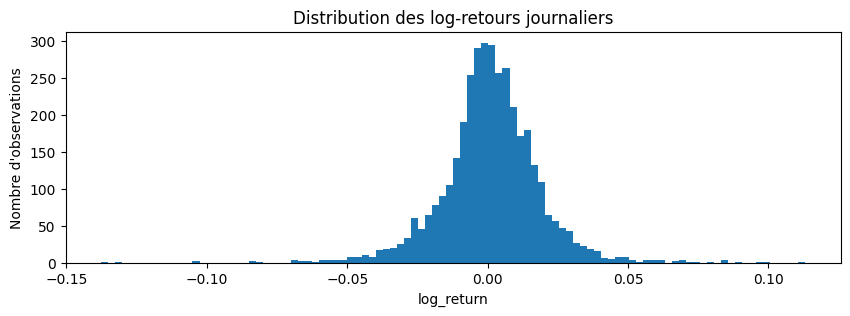

In [54]:
df_aapl["log_return"].hist(bins=100, figsize=(10, 3))
plt.title("Distribution des log-retours journaliers")
plt.xlabel("log_return")
plt.ylabel("Nombre d'observations")
plt.grid(False)
plt.show()


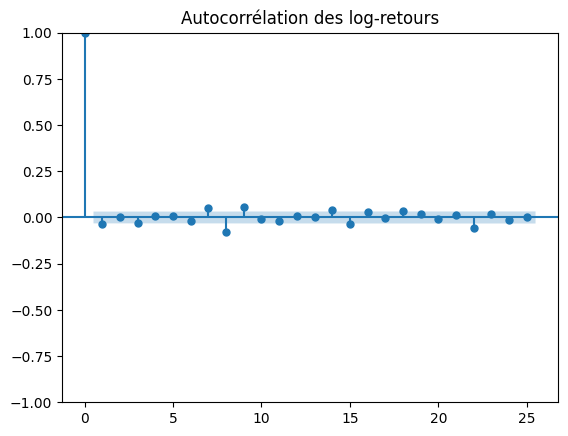

In [55]:
plot_acf(df_aapl["log_return"], lags=25)
plt.title("Autocorrélation des log-retours")
plt.show()


#### AR 1, 2, 5, 10

In [56]:
# Choisir le nombre de lags (ex: p = 1, 2, 5, 10)
for p in [1, 2, 5, 10]:
    features = [f"ret_lag_{i}" for i in range(1, p + 1)]
    X_all = df_aapl[features].values
    y_all = df_aapl["log_return"].values

    # Paramètres de la walk-forward CV
    test_size = 50
    fold_size = 200
    step = test_size

    predictions = []
    truths = []

    # WFCV :
    for start in range(0, len(X_all) - fold_size - test_size, step):
        train_X = X_all[start : start + fold_size]
        train_y = y_all[start : start + fold_size]
        test_X = X_all[start + fold_size : start + fold_size + test_size]
        test_y = y_all[start + fold_size : start + fold_size + test_size]

        # OLS
        beta = np.linalg.pinv(train_X) @ train_y
        y_pred = test_X @ beta

        predictions.extend(y_pred)
        truths.extend(test_y)

    # MSE cross validee
    error = np.mean((np.array(predictions) - np.array(truths)) ** 2)
    print(f"AR({p}) - MSE: {error:.6f}")


AR(1) - MSE: 0.000311
AR(2) - MSE: 0.000313
AR(5) - MSE: 0.000318
AR(10) - MSE: 0.000323


#### RF 

RF ne voit pas la données chronologiquement. Pour ne pas violer la strucutre temporelle, il faut être vigilant à entrainer un modèle seulement sur les retours passés puis le tester sur le futur. 

In [57]:
lags = list(range(1, 11))
features = [f"ret_lag_{i}" for i in lags]
X_all = df_aapl[features].values
y_all = df_aapl["log_return"].values

test_size = 50
fold_size = 200
step = test_size

mse_scores = []

for start in range(0, len(X_all) - fold_size - test_size, step):
    X_train = X_all[start : start + fold_size]
    y_train = y_all[start : start + fold_size]
    X_test = X_all[start + fold_size : start + fold_size + test_size]
    y_test = y_all[start + fold_size : start + fold_size + test_size]

    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

print(f"MSE moyenne sur les folds : {np.mean(mse_scores):.6f}")


MSE moyenne sur les folds : 0.000338


#### ResNet

In [ ]:
# Reshape pour CNN 1D : (samples, sequence_length, channels)
X_all = X_all.reshape(X_all.shape[0], X_all.shape[1], 1)
y_all = y_all.reshape(-1, 1)  # compatibilité avec MSELoss

In [59]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + residual)

class ResNet1D(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=16, num_blocks=3):
        super().__init__()
        self.input_conv = nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_channels) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channel, seq)
        x = self.input_conv(x)
        x = self.res_blocks(x)
        x = x.mean(dim=2)  # Global average pooling over time
        return self.output_layer(x)

In [68]:
# Paramètres de la CV
fold_size = 200
test_size = 50
step = test_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mse_scores = []

for start in range(0, len(X_all) - fold_size - test_size, step):
    end_train = start + fold_size
    start_test = end_train
    end_test = start_test + test_size

    # Extraire les folds
    X_train = torch.tensor(X_all[start:end_train], dtype=torch.float32)
    y_train = torch.tensor(y_all[start:end_train], dtype=torch.float32)
    X_test = torch.tensor(X_all[start_test:end_test], dtype=torch.float32)
    y_test = torch.tensor(y_all[start_test:end_test], dtype=torch.float32)

    # DataLoader
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)

    # Modèle
    model = ResNet1D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    losses_per_epoch = [] # for plot

    # Entraînement simple (5 epochs)
    model.train()
    for epoch in range(10):
        batch_losses = []  # pour stocker les losses de chaque batch
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = xb.unsqueeze(-1)
            yb = yb.unsqueeze(-1)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())  # stocke la loss du batch
    
        epoch_loss = np.mean(batch_losses)
        losses_per_epoch.append(epoch_loss)

    # Évaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test.to(device).unsqueeze(-1)).cpu().numpy().flatten()
        truths = y_test.numpy().flatten()
        mse = np.mean((preds - truths) ** 2)
        mse_scores.append(mse)

print(f"MSE moyenne (ResNet) : {np.mean(mse_scores):.6f}")


MSE moyenne (ResNet) : 0.000319


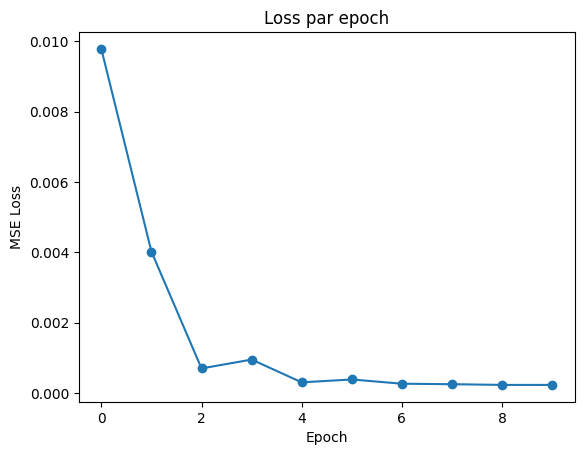

In [69]:
plt.plot(losses_per_epoch, marker='o')
plt.title("Loss par epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()